In [2]:
print "Loading libraries and processed file. Focus on the monthly trend of Product_0606:"
import pandas as pd
from statsmodels.tsa.arima_model import ARIMA
import matplotlib.pyplot as plt

processed = pd.read_csv("../data/processed/processed.csv")
def agg_attrs_by_month(attr_dict, return_raw=False):
    df = processed
    for attr in attr_dict:
        df = df[df[attr] == attr_dict[attr]]
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values(by=['Date']).dropna()
    df = df.set_index('Date')
    df.groupby(pd.Grouper(freq="M"))
    sum = df.groupby(pd.Grouper(freq="M")).sum()
    data = list(sum['Order_Demand'])
    dates = list(sum.index)
    if return_raw is True:
        return sum['Order_Demand'], dates
    return data, dates
df, dates = agg_attrs_by_month({'Product_Code': 'Product_0606'}, return_raw=True)
print df.head()

Loading libraries and processed file. Focus on the monthly trend of Product_0606:
Date
2012-01-31    2200
2012-02-29    1750
2012-03-31    4450
2012-04-30    1000
2012-05-31    1575
Freq: M, Name: Order_Demand, dtype: int64


In [12]:
print "Try Augmented Dickey Fuller test to see if differencing is needed"
from statsmodels.tsa.stattools import adfuller
result = adfuller(df)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
# ADF Statistic: -39.97
# p-value: 0.00, can set differencing to 0
print "p-value > 0.05, refuse to deny Hypothesis H0 and need to set differencing. Set d to 1 first"

Try Augmented Dickey Fuller test to see if differencing is needed
ADF Statistic: -2.830642
p-value: 0.054028
p-value > 0.05, refuse to deny Hypothesis H0 and need to set differencing. Set d to 1 first


Create ARIMA model with p, d, q of 2, 1, 1
Model trained. kde of residual:
                             ARIMA Model Results                              
Dep. Variable:         D.Order_Demand   No. Observations:                   59
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -486.371
Method:                       css-mle   S.D. of innovations            900.637
Date:                Thu, 07 Nov 2019   AIC                            982.741
Time:                        20:52:50   BIC                            993.129
Sample:                    02-29-2012   HQIC                           986.796
                         - 12-31-2016                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   19.0818     10.821      1.763      0.083      -2.128      40.291
ar.L1.D.Order_Demand    -0

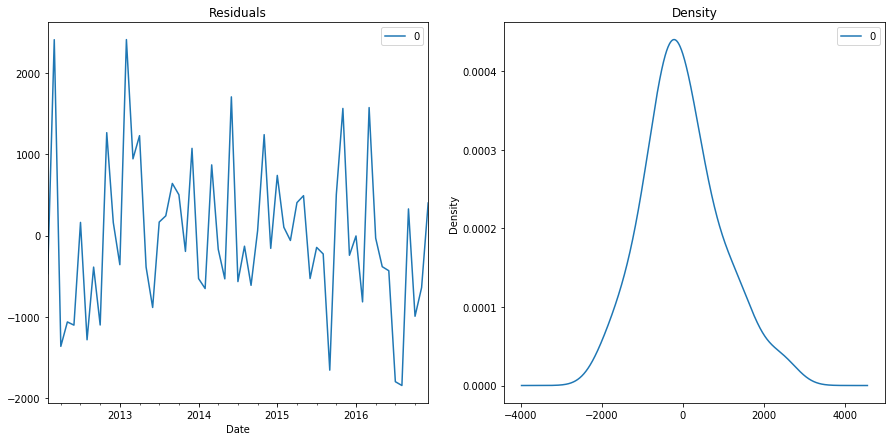

In [6]:
print "Create ARIMA model with p, d, q of 2, 1, 1"
model = ARIMA(df, order=(2, 1, 1))
model_fit = model.fit()
print "Model trained. kde of residual:"
print model_fit.summary()
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)

fig, ax = plt.subplots(1, 2, figsize=(15, 7))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

use the trained ARIMA model to predict


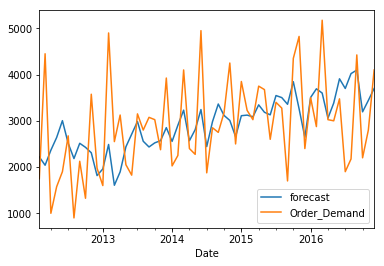

In [9]:
print "use the trained ARIMA model to predict"
model_fit.plot_predict(dynamic=False)
plt.show()
# not so accurate on spikes

In [11]:
print "Splitting train/test set to try out ARIMA order"
index_p85 = int(len(df.index) * 0.85)
train = df[:index_p85]
test = df[index_p85:]
# Build Model
print "Try 3 AR lag items and 1 lagged error"
model = ARIMA(train, order=(3, 2, 1))
fitted = model.fit(disp=-1)
print fitted.summary()
print "All Ps are mostly < 0.05"

Splitting train/test set to try out ARIMA order
Try 3 AR lag items and 1 lagged error
                             ARIMA Model Results                              
Dep. Variable:        D2.Order_Demand   No. Observations:                   49
Model:                 ARIMA(3, 2, 1)   Log Likelihood                -411.206
Method:                       css-mle   S.D. of innovations            987.691
Date:                Thu, 07 Nov 2019   AIC                            834.411
Time:                        21:03:22   BIC                            845.762
Sample:                    03-31-2012   HQIC                           838.718
                         - 03-31-2016                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     1.3603      3.264      0.417      0.679      -5.038       7.758
ar.L1.D2.Ord

Use the tweaked model for forecasting:
Plot both the predicted value and real value on test set


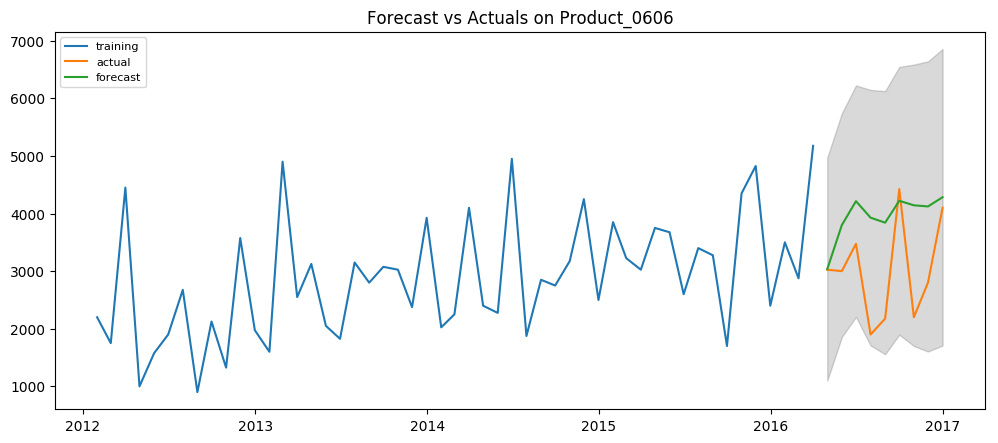

In [48]:
print "Use the tweaked model for forecasting:"
fc, se, conf = fitted.forecast(9, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
print "Plot both the predicted value and real value on test set"
plt.figure(figsize=(12, 5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
plt.title('Forecast vs Actuals on {}'.format('Product_0606'))
plt.legend(loc='upper left', fontsize=8)
plt.show()
# changing order from 1,1,1 to 3,2,1

Train ARIMA model on Product_0458 in warehouse 'Whse_S':
                             ARIMA Model Results                              
Dep. Variable:        D2.Order_Demand   No. Observations:                   49
Model:                 ARIMA(3, 2, 1)   Log Likelihood                -317.846
Method:                       css-mle   S.D. of innovations            149.055
Date:                Thu, 07 Nov 2019   AIC                            647.691
Time:                        21:43:36   BIC                            659.042
Sample:                    03-31-2012   HQIC                           651.998
                         - 03-31-2016                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.4288      0.660     -0.650      0.519      -1.722       0.864
ar.L1.D2.Order_Demand    -0.6124      0.1

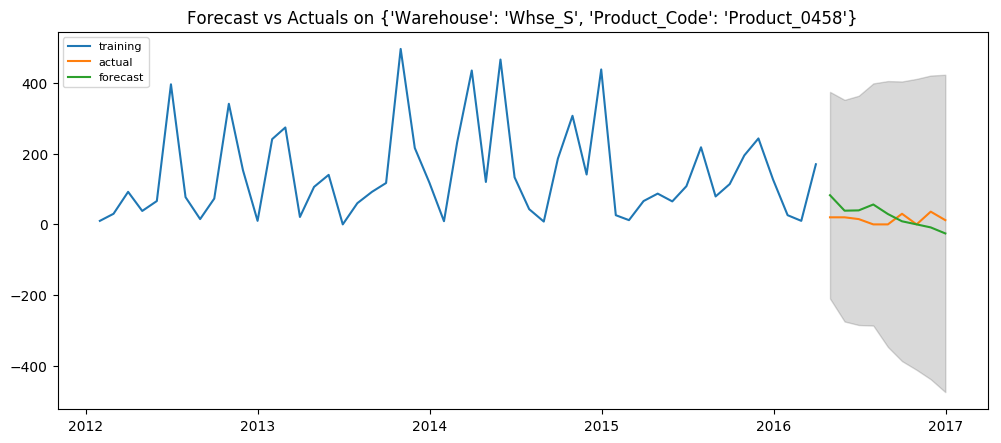

In [46]:
def train_arima_predict_n_plot(attr_dict):
    df, dates = agg_attrs_by_month(attr_dict, return_raw=True)
    
    index_p85 = int(len(df.index) * 0.85)
    train = df[:index_p85]
    test = df[index_p85:]

    model = ARIMA(train, order=(3, 2, 1))
    fitted = model.fit(disp=-1)
    print fitted.summary()

    fc, se, conf = fitted.forecast(len(test.index), alpha=0.05)  # 95% conf
    fc_series = pd.Series(fc, index=test.index)
    lower_series = pd.Series(conf[:, 0], index=test.index)
    upper_series = pd.Series(conf[:, 1], index=test.index)
    plt.figure(figsize=(12, 5), dpi=100)
    plt.plot(train, label='training')
    plt.plot(test, label='actual')
    plt.plot(fc_series, label='forecast')
    plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
    plt.title('Forecast vs Actuals on {}'.format(attr_dict))
    plt.legend(loc='upper left', fontsize=8)
    plt.show()
print "Train ARIMA model on Product_0458 in warehouse 'Whse_S':"
train_arima_predict_n_plot({'Product_Code': 'Product_0458', 'Warehouse': 'Whse_S'})

Train ARIMA model on the entire dataset of warehouse 'Whse_S':
                             ARIMA Model Results                              
Dep. Variable:        D2.Order_Demand   No. Observations:                   55
Model:                 ARIMA(3, 2, 1)   Log Likelihood                -915.962
Method:                       css-mle   S.D. of innovations        3948591.994
Date:                Thu, 07 Nov 2019   AIC                           1843.925
Time:                        21:44:51   BIC                           1855.969
Sample:                    08-31-2011   HQIC                          1848.582
                         - 02-29-2016                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -3.861e+04   2.13e+04     -1.816      0.075   -8.03e+04    3055.570
ar.L1.D2.Order_Demand    -0.5302   

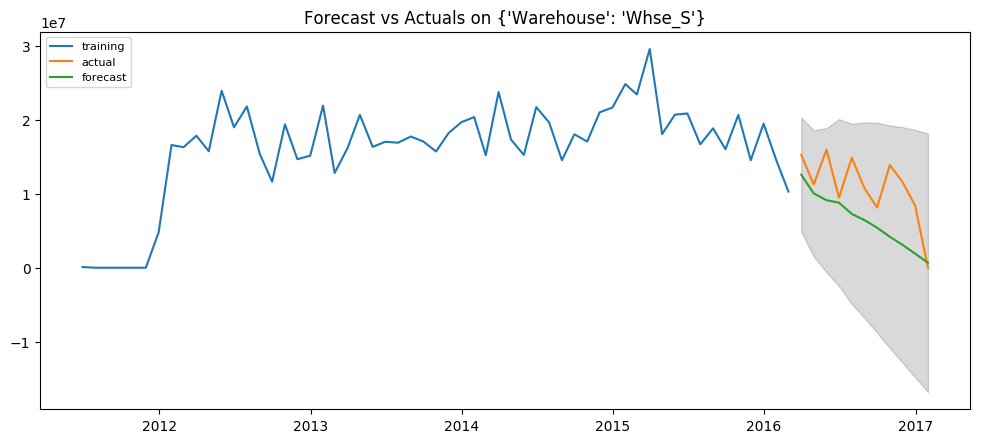

In [49]:
print "Train ARIMA model on the entire dataset of warehouse 'Whse_S':"
train_arima_predict_n_plot({'Warehouse': 'Whse_S'})

Train ARIMA model on the entire dataset of category 'Category_017':
                             ARIMA Model Results                              
Dep. Variable:        D2.Order_Demand   No. Observations:                   49
Model:                 ARIMA(3, 2, 1)   Log Likelihood                -411.053
Method:                       css-mle   S.D. of innovations           1001.388
Date:                Thu, 07 Nov 2019   AIC                            834.106
Time:                        21:44:55   BIC                            845.457
Sample:                    03-31-2012   HQIC                           838.412
                         - 03-31-2016                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.5428      4.921     -0.110      0.913     -10.188       9.102
ar.L1.D2.Order_Demand    -0.66

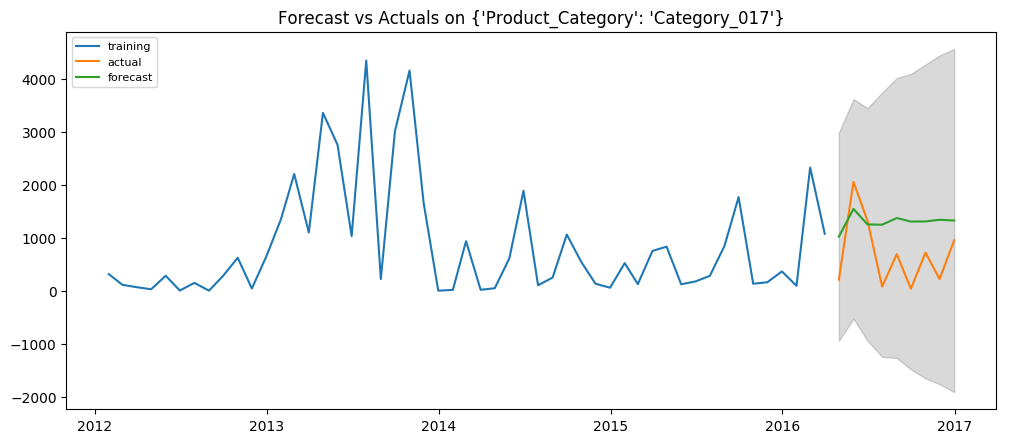

In [50]:
print "Train ARIMA model on the entire dataset of category 'Category_017':"
train_arima_predict_n_plot({'Product_Category': 'Category_017'})

In [45]:
print "The trained ARIMA model seems not sensitive enough on spikes and valleys"

The trained ARIMA model seems not sensitive enough on spikes and valleys
